The notebook automates preprocess of data on any of the 128 UCR time series classification datasets. Download here: http://www.timeseriesclassification.com/index.php, unzip, and set your pwd there to run this notebook as is.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
from pathlib import Path
from scipy.io import arff
from sklearn.metrics import confusion_matrix

In [2]:
DATAPATH = Path.cwd()

In [3]:
list(DATAPATH.iterdir())

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/resnet.py'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/models'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/environment.yml'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/__pycache__')]

In [4]:
def load_df(task):
    dfs = []
    for file in ['TRAIN', 'TEST']:
        filename = f'{task}/{task}_{file}.arff'
        data = arff.loadarff(DATAPATH/filename)
        dfs.append(pd.DataFrame(data[0]))
    return dfs
    
def cleanup(df):
    df.columns = [k for k in range(df.shape[1]-1)]+['target']
    for k in df.columns[:-1]:
        df[k] = df[k].astype('float')
    if df.target.dtype == 'object':
        df['target'] = df['target'].apply(lambda x: x.decode('ascii')).astype('int')
    if sorted(df.target.unique()) != list(np.arange(df.target.nunique())):
        new_targs = pd.DataFrame({'target':df.target.unique()}).reset_index()
        df = pd.merge(df, new_targs, left_on='target', right_on='target').drop('target',axis=1).rename(columns={'index':'target'})
    ts = pd.melt(df.reset_index(), id_vars=['index','target'], var_name='time').rename(columns={'index':'id'})
    ts = ts.groupby(['id','time','target']).value.mean().reset_index()
    return df, ts

def graph_ts(ts):
    "super slow"   
    fig, axes = plt.subplots(figsize=(15,5))
    sns.lineplot(data=ts, x='time', hue='target', y='value', units='id', estimator=None, ax=axes)
    return None

In [5]:
task = 'Adiac'
df_train, df_test = load_df(task)
df_train, ts_train = cleanup(df_train)
df_test, ts_test = cleanup(df_train)

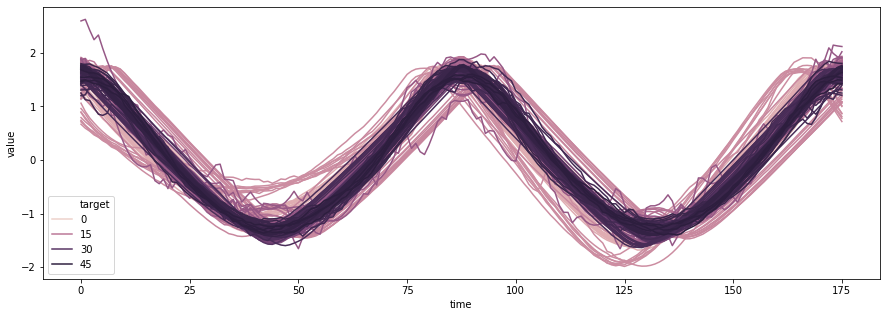

In [6]:
graph_ts(ts_train)

# Torch

In [7]:
import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [8]:
def get_ds(df):
    return TensorDataset(torch.Tensor(df.values[:,:-1].astype('float')).unsqueeze(dim=1), 
                         torch.Tensor(df.values[:,-1].astype('int')).long())

In [9]:
num_classes = df_train.target.nunique(); num_classes

37

In [10]:
tr_ds, val_ds = get_ds(df_train), get_ds(df_test)

In [11]:
def create_databunch(tr_ds, val_ds):
    train_dl = DataLoader(tr_ds, batch_size=64, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=64, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [12]:
db = create_databunch(tr_ds, val_ds)

Testing dims at input/output

In [13]:
tx, ty = next(iter(db.valid_dl))

In [14]:
tx.shape, ty.shape

(torch.Size([64, 1, 176]), torch.Size([64]))

## Convolutions

In [15]:
from resnet import AdaptiveConcatPool1d, res_block_1d

In [16]:
def create_resnet(ni, nout): 
    "Basic 1D resnet builder, as seen on paper https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7966039&tag=1"
    return nn.Sequential(conv_layer(ni, 64, ks=9, padding=4, is_1d=True),
                         res_block_1d(64), 
                         conv_layer(64, 128, ks=9, padding=4, is_1d=True),
                         res_block_1d(128),
                         conv_layer(128, 128, ks=9, padding=4, is_1d=True),
                         res_block_1d(128), 
                         AdaptiveConcatPool1d(),
                         Flatten(),
                         nn.Sequential(*bn_drop_lin(2*128,nout))
                        )

In [17]:
model = create_resnet(1, num_classes); model

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): MergeLayer()
    )
  )
  (2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [18]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[accuracy],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


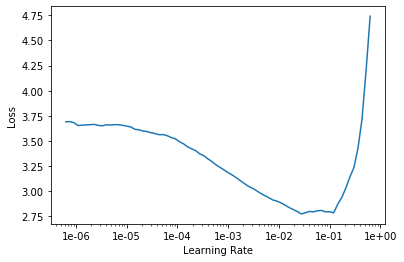

In [19]:
learn_res.lr_find(); learn_res.recorder.plot()

In [22]:
learn_res.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.114625,0.993692,0.753846,00:00
1,1.038060,1.087763,0.674359,00:00
2,1.030772,1.074724,0.694872,00:00
3,1.022028,1.152839,0.656410,00:00
4,1.008011,1.232459,0.615385,00:00
5,1.010214,0.915574,0.746154,00:00
6,0.986355,1.429950,0.543590,00:00
7,0.966591,0.909347,0.766667,00:00
8,0.927862,0.837478,0.797436,00:00
9,0.891233,0.778807,0.825641,00:00


In [23]:
p, t = learn_res.get_preds()

In [24]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

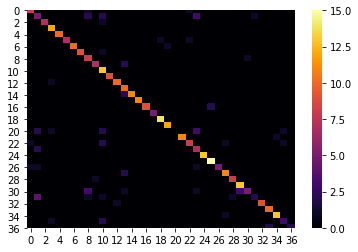

In [32]:
sns.heatmap(get_cm(p,t), cmap='inferno')